Number of classes: 2
Epoch [1/5], Loss: 0.5780762956952149
Validation Loss: 0.37180644273757935, Accuracy: 82.86516853932584
Epoch [2/5], Loss: 0.3720667748799864
Validation Loss: 0.3631410685678323, Accuracy: 84.8314606741573
Epoch [3/5], Loss: 0.27643572089244733
Validation Loss: 0.29895734041929245, Accuracy: 87.07865168539325
Epoch [4/5], Loss: 0.22286467352565728
Validation Loss: 0.22686306138833365, Accuracy: 91.29213483146067
Epoch [5/5], Loss: 0.19024319043558724
Validation Loss: 0.19196214899420738, Accuracy: 92.69662921348315
Test Loss: 0.26343961618840694, Test Accuracy: 91.34078212290503


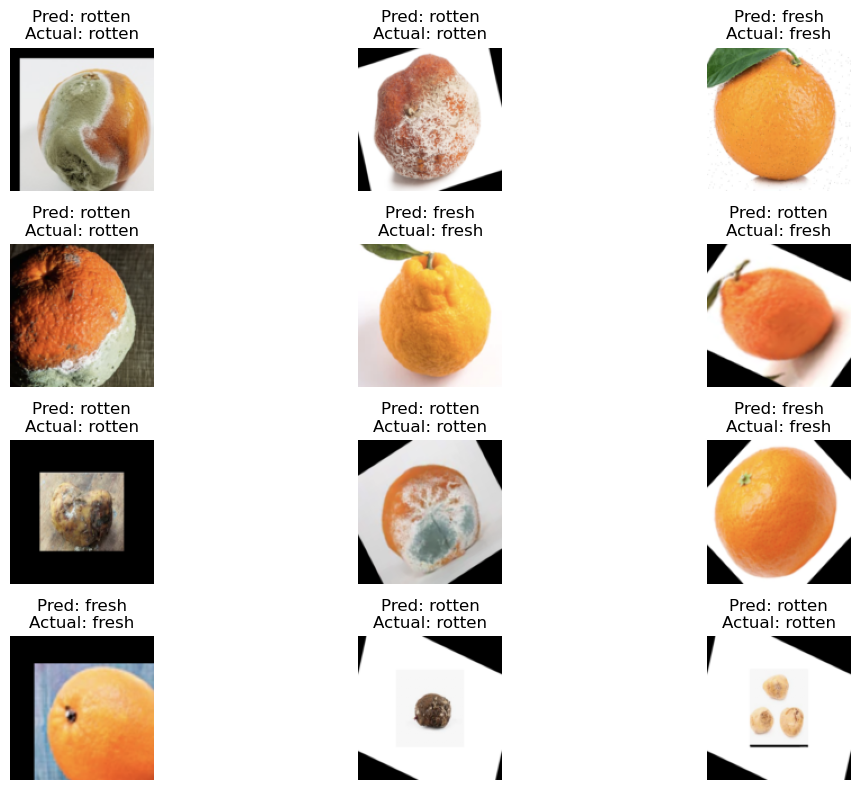

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

# Path to your dataset
data_dir = '/Users/mahadevreddy/Downloads/sud - Copy'

# Data transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Loading the dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Dynamically determine the number of classes
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

# Splitting the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)  # Output layer matches number of classes
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = CNNModel(num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}')

# Testing the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {100 * correct / total}')

# Visualizing results
def show_images(images, titles, rows=4, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    for i, (img, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols]
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Displaying some sample images with their predictions
num_images = 12
indices = random.sample(range(len(test_dataset)), num_images)
images, titles = [], []

model.eval()
with torch.no_grad():
    for idx in indices:
        image, label = test_dataset[idx]
        images.append(image)
        
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)
        actual_class = dataset.classes[label]
        predicted_class = dataset.classes[predicted.item()]
        
        titles.append(f'Pred: {predicted_class}\nActual: {actual_class}')

show_images(images, titles)


In [2]:
import torch
num_classes = 2  # Replace with the actual number of classes in your dataset
model = CNNModel(num_classes)

# Save the model's state dictionary
torch.save(model.state_dict(), 'model.pth')

In [3]:
num_classes = 2  # Update this with the actual number of classes
model = CNNModel(num_classes)

# Load the model's state dictionary with weights_only=True
model.load_state_dict(torch.load('model.pth', weights_only=True))

# Print model architecture
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [5]:
import cv2
import easyocr
import tensorflow as tf
import csv
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image


# Load the model
num_classes = 2  # Update this with the actual number of classes
model = CNNModel(num_classes)

# Load the model's state dictionary with weights_only=True
model.load_state_dict(torch.load('model.pth', weights_only=True))
model.eval()  # Set the model to evaluation mode

def capture_image(image_path="captured_image.jpg"):
    """Capture an image from the USB camera and save it."""
    try:
        cap = cv2.VideoCapture(0)  # 0 is the default camera
        if not cap.isOpened():
            raise Exception("Could not open camera.")

        while True:
            ret, frame = cap.read()
            if not ret:
                raise Exception("Failed to capture image")

            cv2.imshow("Image", frame)
            if cv2.waitKey(1) & 0xFF == ord('c'):
                cv2.imwrite(image_path, frame)
                break

        cap.release()
        cv2.destroyAllWindows()
        return image_path
    except Exception as e:
        print(f"Error capturing image: {e}")
        return None

def preprocess_image(image_path):
    """Preprocess the captured image for further analysis."""
    try:
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh_image = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)
        temp_image_path = 'temp_image.png'
        cv2.imwrite(temp_image_path, thresh_image)
        return temp_image_path
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

def extract_text(image_path):
    """Extract text from the image using EasyOCR."""
    try:
        reader = easyocr.Reader(['en'])
        image = cv2.imread(image_path)
        results = reader.readtext(image)
        text = ' '.join([result[1] for result in results])
        return text
    except Exception as e:
        print(f"Error extracting text: {e}")
        return ""

def classify_image(image_path):
    """Classify the image using a pre-trained MobileNetV2 model."""
    try:
        model = tf.keras.applications.MobileNetV2(weights="imagenet")
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        input_array = tf.keras.preprocessing.image.img_to_array(image)
        input_array = tf.expand_dims(input_array, axis=0)
        input_array = tf.keras.applications.mobilenet_v2.preprocess_input(input_array)
        predictions = model.predict(input_array)
        predicted_class = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=1)
        return predicted_class
    except Exception as e:
        print(f"Error classifying image: {e}")
        return None

def health_check(image_path):
    """Check if the image is healthy (e.g., no defects or anomalies)."""
    try:
        image = Image.open(image_path)
        image.show()
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])
        
        image_tensor = transform(image)
        image_tensor = image_tensor.unsqueeze(0)
        
        model.eval()
        
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            predicted_class = dataset.classes[predicted.item()]
            print(f'Predicted Class: {predicted_class}')
            return predicted_class
    except Exception as e:
        print(f"Error checking health: {e}")
        return False

def quality_check(health_check_result):
    """Perform a quality check based on the health check result."""
    if health_check_result == "fresh":
        return "Product Passed"
    else:
        return "Product Failed"

def log_results(image_name, classification, result):
    """Log the quality control results to a CSV file."""
    try:
        with open("quality_control_log.csv", mode='a') as file:
            writer = csv.writer(file)
            writer.writerow([image_name, classification, result])
    except Exception as e:
        print(f"Error logging results: {e}")

def main():
    """Main function to orchestrate the image capture, processing, and quality control."""
    image_path = capture_image()
    if image_path:
        processed_image = preprocess_image(image_path)
        extracted_text = extract_text(image_path)
        print("Extracted Text:", extracted_text)
        classification_result = classify_image(image_path)
        if classification_result:
            classification_name = classification_result[0][0][1]
            print("Classification Result:", classification_name)
        else:
            classification_name = "Unknown"
        health_status = health_check(image_path)
        print("Health Status:", health_status)
        decision = quality_check(health_status)
        print("Quality Control Decision:", decision)
        log_results(image_path, classification_name, decision)

if __name__ == "__main__":
    main()


Extracted Text: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
Classification Result: custard_apple
Predicted Class: fresh
Health Status: fresh
Quality Control Decision: Product Passed
